# Analysis of pre- and post-incubation chromatographic data

In this notebook we provide a detailed analysis of the assigned spectra from the GC-FID and LC-Orbitrap-MS.
Different statistical methods were used to differentiate between synthesis methods.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import seaborn as sns

## Use synthesis method as class variable

### Read data
In the long format, each compound for each analyis has its own row.
In the wide format, each row is an experiment.

In [2]:
long = pd.read_csv(f'data/Data_Fentanyl_All_Normalized.csv', sep=';', header=0)

In [3]:
# selection of analysis method
selection_analysis = 'LC-Orbitrap-MS' # or 'GC-FID'

# selection of incubation
selection_incubation = 'post' # or 'pre'

selected_long = long.loc[
    (long['Analysis'] == selection_analysis) & (long['Incubation'] == selection_incubation)
].copy()

#Addition of Experiment column
selected_long['Experiment'] = (
    selected_long["Synthesis"] + selected_long["N"].astype(str) + '-' + selected_long["Incubation"] + 
    '-' + selected_long["Storage"]
)

In [4]:
selected_wide = selected_long.pivot_table(
    index=["Synthesis", "N", "Incubation", "Storage"], 
    columns='Compound'
).fillna(0)

In [5]:
#Map compound to id.
header = pd.read_csv("data/Compound Identification New.csv", sep=';', index_col='Compound ID').sort_index(0)
header

,Name
Compound ID,
A,aniline
AA,MFCD01829346
AB,MFCD01916771
B,4-piperidone
C,gamma-Aminobutyric acid
D,Muscimol
E,Tetramethylurea
F,Tris(hydroxymethyl)aminomethane
G,N-ethyl benzenamine


### Data evaluation

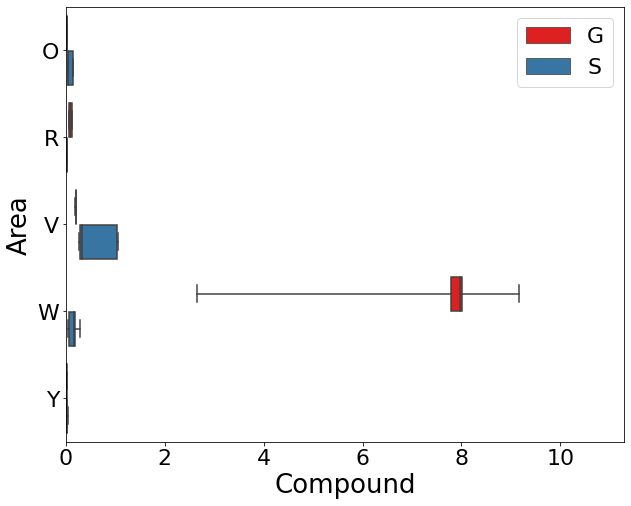

In [6]:
palette = dict(G="#ff0000", S="#2778b3")

#Select impurities for the boxplot
select_compounds = ['O', 'R', 'V', 'W', 'Y']

plt.figure(figsize=(10,8))
plt.xlim(0, max(selected_long['Area']))

sns.boxplot(
    x='Area', 
    y='Compound', 
    hue='Synthesis', 
    data=selected_long.loc[selected_long['Compound'].isin(select_compounds)],
    palette=palette,
    whis=np.inf,
)
plt.ylabel("Area", fontsize = 26)
plt.xlabel("Compound", fontsize = 26);
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.legend(fontsize = 22)

### Correlation

<AxesSubplot:xlabel='None-Compound', ylabel='None-Compound'>

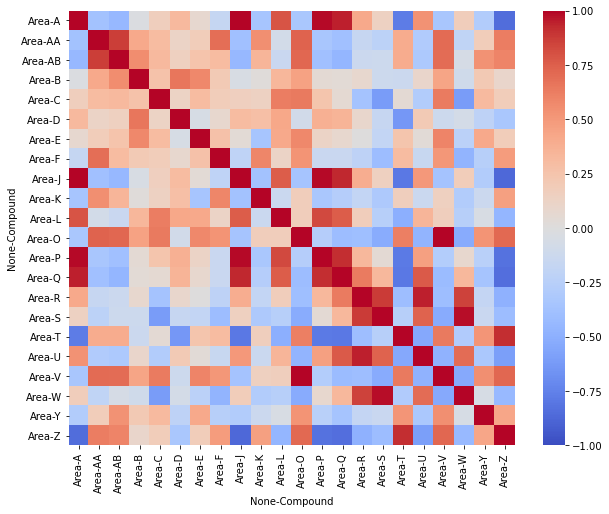

In [7]:
plt.figure(figsize=(10,8))
sns.heatmap(selected_wide.corr(), cmap='coolwarm', vmin=-1)

### Ordinary aggregating

Get the mean and 95% bootstrap confidence interval for the normalized area for the most important impurities using different methods.

<AxesSubplot:xlabel='Synthesis', ylabel='Area'>

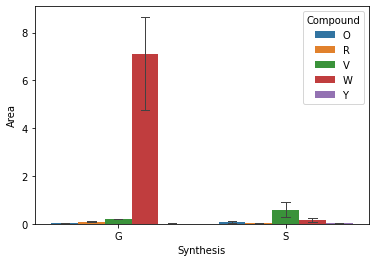

In [8]:
#Select impurities for the barplot
select_compounds = ['O', 'R', 'V', 'W', 'Y']

sns.barplot(
    x='Synthesis', 
    y='Area', 
    hue='Compound', 
    data=selected_long.loc[selected_long['Compound'].isin(select_compounds)], 
    errwidth=1, capsize=.05
)

### PCA
We check robustness of the obtained PCA by leave-one-out validation. We observe only minor differences in the explained variance when one sample is left out.

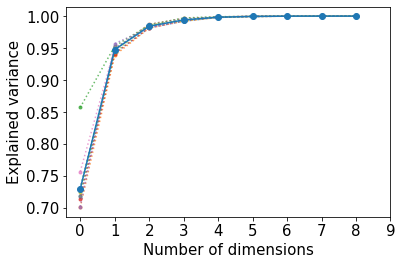

In [9]:
pca = PCA()
pca.fit(selected_wide)

for leaveout in selected_wide.index:
    pca.fit(selected_wide.drop(leaveout))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), alpha=.7, ls=':', marker='.')
    
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of dimensions", fontsize = 15)
plt.ylabel("Explained variance", fontsize = 15)
plt.xticks(np.arange(0, 10, step=1),fontsize=15)
plt.yticks(fontsize=15)
plt.gcf().subplots_adjust(bottom=0.15, left = 0.15)

#### Score plot 
The different synthesis routes are well separated on the first component of the PCA.

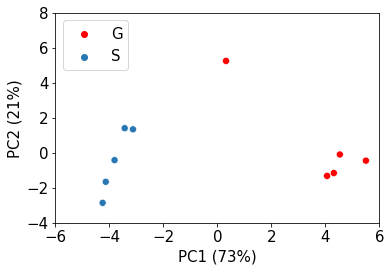

In [10]:
pca = PCA()
pca.fit(selected_wide)

pca_data = pd.DataFrame(pca.transform(selected_wide)[:,0:2], index=selected_wide.index).reset_index().rename(
    columns={0: 'PC1', 1: 'PC2'}
)

sns.scatterplot(x='PC1', y='PC2', data=pca_data, hue='Synthesis', palette=palette, s=50) 

#If incubation and synthesis combined
# sns.scatterplot(0, 1, data=pca_data, hue='Synthesis', style='Incubation', palette=pal, s=50)

plt.xlabel(f'PC1 ({round(pca.explained_variance_ratio_[0],2):.0%})', fontsize = 15)
plt.ylabel(f'PC2 ({round(pca.explained_variance_ratio_[1],2):.0%})', fontsize = 15);
plt.legend(fontsize=15, loc='upper left')
plt.xticks(np.arange(-6, 8, step=2), fontsize=15)
plt.yticks(np.arange(-4, 10, step=2), fontsize=15)
plt.gcf().subplots_adjust(bottom=0.15, left = 0.15)

#### PCA loadings
The following two plots contain the same information.

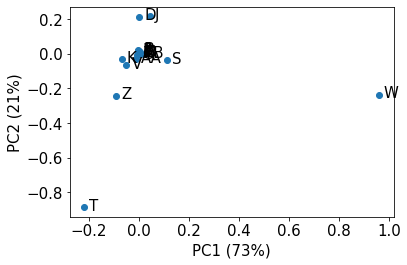

In [11]:
loadings = pd.DataFrame(pca.components_, columns=selected_wide['Area'].columns).T[[0, 1]]

plt.scatter(loadings[0], loadings[1])
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.0%})', fontsize = 15)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.0%})', fontsize = 15)
for label, x, y in loadings.itertuples():
    if x>-0.3 or y>-0.3:
       plt.annotate(label, (x, y), xytext=(5, -3), textcoords=('offset pixels', 'offset pixels'), fontsize=15)


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.gcf().subplots_adjust(left=0.15, bottom=0.15)

<AxesSubplot:xlabel='Compound'>

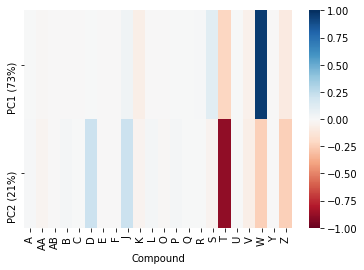

In [12]:
sns.heatmap(
    loadings.T, vmin=-1, vmax=1, cmap='RdBu', 
    yticklabels=[
        f"PC1 ({pca.explained_variance_ratio_[0]:.0%})",
        f"PC2 ({pca.explained_variance_ratio_[1]:.0%})"
    ]
)

### Linear Discriminant Analysis

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(X=selected_wide, y=selected_wide.index.get_level_values('Synthesis'))

lda = pd.DataFrame(clf.transform(selected_wide)[:,0], index=selected_wide.index)
lda

0
Synthesis N   Incubation Storage          
G         1.0 post       RT      -2.219574
                         freezer -0.560550
          2.0 post       freezer -2.155742
          3.0 post       RT      -2.731575
                         freezer -3.586902
S         1.0 post       freezer  0.991054
          2.0 post       RT       1.944685
                         freezer  3.175480
          3.0 post       RT       3.004720
                         freezer  2.138403

([], [])

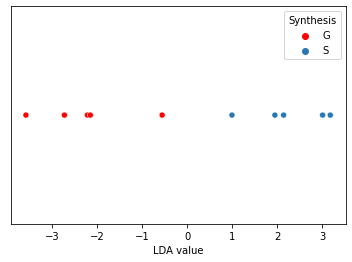

In [14]:
sns.scatterplot(x=lda[0], y=np.ones(len(lda)), hue=selected_wide.index.get_level_values('Synthesis'), palette=palette)
plt.xlabel('LDA value')
plt.yticks(ticks=[])

#### Likelihood
The likelihoods are determined from the ratio of the kernel density estimation at a given LDA value.

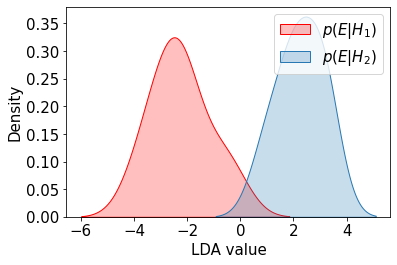

In [15]:
g = lda[0][np.array(selected_wide.index.get_level_values('Synthesis')) == 'G']
s = lda[0][np.array(selected_wide.index.get_level_values('Synthesis')) == 'S']

sns.kdeplot(g, shade=True, bw_adjust=1, label=r'$p(E|H_1)$', color=palette['G'])
sns.kdeplot(s, shade=True, bw_adjust=1, label=r'$p(E|H_2)$', color=palette['S'])
plt.xlabel('LDA value', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.legend(fontsize=15)
plt.gcf().subplots_adjust(left=0.15, bottom=0.15)

#### Likelihood function
The following likelihood function calculates a given LDA-score (as calculated by `LinearDiscriminantAnalysis.fit()`) to the following function:
$LR=\frac{p\left(E|H_1\right)}{p\left(E|H_2\right)}$
- $H_1$: The victim has consumed fentanyl produced with the Gupta method.
- $H_2$: The victim has consumed fentanyl produced with the Siegrief method.



In [16]:
def likelihood(lda_score, kde1=stats.gaussian_kde(g), kde2=stats.gaussian_kde(s)): return kde1(lda_score) / kde2(lda_score) 

In [17]:
likelihood(0)

array([2.11577486])